In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sacrebleu.metrics import BLEU
from collections import Counter
from typing import Generator, Tuple

In [3]:
SOURCES = "../../data/en-fr/raw/test.fr"
REFERENCES = "../../data/en-fr/raw/test.en"
TRAIN_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/train.fr"
TEST_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/test.fr"

In [4]:
def shr_generator(hypotheses_path: str) -> Generator[Tuple[str, str, str, str], None, None]:
    with open(SOURCES, "r") as sources, open(hypotheses_path, "r") as hypotheses, open(REFERENCES, "r") as references, open(TEST_SOURCES_TOKENIZED) as source_tokenized:
        for s, h, r, st in zip(sources, hypotheses, references, source_tokenized):
            yield s.strip(), h.strip(), r.strip(), st.strip()

bleu = BLEU(effective_order=True)

word_counts = Counter()

with open(TRAIN_SOURCES_TOKENIZED) as f:
    for line in f:
        word_counts += Counter(line.strip().split(" "))

def unknown_ratio(tokenized_sentence: str) -> float:
    unknown = 0
    total = 0
    for token in tokenized_sentence.split(" "):
        if token not in word_counts:
            unknown += 1
        total += 1
    return unknown / total

def rare_ratio(tokenized_sentence: str, threshold: float = 0.001) -> float:
    rare = 0
    total = 0
    train_size = sum(word_counts.values())
    for token in tokenized_sentence.split(" "):
        if word_counts[token] / train_size < threshold:
            rare += 1
        total += 1
    return rare / total

def load_data(hypotheses_path: str) -> pd.DataFrame:
    shr = [x for x in shr_generator(hypotheses_path)]
    df = pd.DataFrame(shr, columns=["source", "hypothesis", "reference", "source_tokenized"])
    df["bleu"] = df.apply(lambda row: bleu.sentence_score(row["hypothesis"], [row["reference"]]).score, axis=1)
    df["source_len"] = df["source"].apply(lambda source: len(str(source)))
    df["unknown_ratio"] = df["source_tokenized"].apply(unknown_ratio)
    df["rare_ratio"] = df["source_tokenized"].apply(rare_ratio)
    return df

In [6]:
SERIES = [
    {"label": "Baseline",    "color": "black", "data": load_data("baseline/translations.p.txt")},
    {"label": "Sentencepiece",         "color": "green", "data": load_data("spm_vanilla/translations/postprocessed_spm_vanilla_fully_trained.txt")},
    {"label": "BT_Baseline", "color": "red",   "data": load_data("backtranslation/doubledata_baseline/translations.txt")},
    {"label": "BT_Sentencepiece", "color": "red",   "data": load_data("backtranslation/doubledata_spm/translations.txt")}
]

In [7]:
def scatter(x, y, **kwargs):
    for series in SERIES:
        plt.scatter(series["data"][x], series["data"][y], c=series["color"], label=series["label"], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

def grouped_line(x, y, bins=10):
    for series in SERIES:
        grouped = series["data"].groupby(pd.cut(series["data"][x], bins=bins)).mean()
        grouped[y].plot(label=series["label"])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

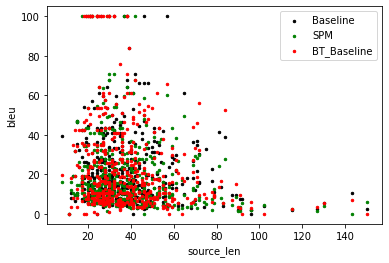

In [8]:
scatter("source_len", "bleu", s=6)

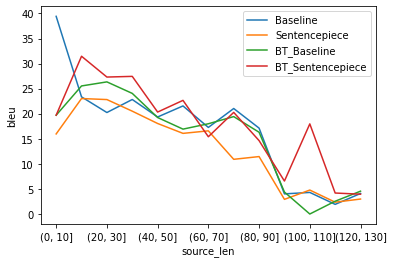

In [8]:
grouped_line("source_len", "bleu", bins=range(0, 150, 10))

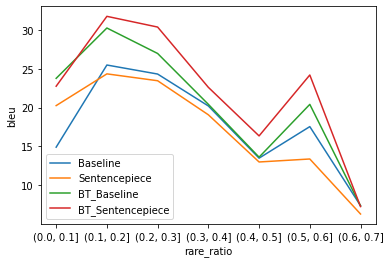

In [9]:
grouped_line("rare_ratio", "bleu", bins=np.arange(0, 1, 0.1))

In [19]:
df[df["bleu"] > 80]

,source,hypothesis,reference,source_tokenized,bleu
24,Vous êtes chanceuse d'avoir un emploi.,You're lucky to have a job.,You're lucky to have a job.,vous êtes chanceuse d&apos; avoir un emploi .,100.000000
86,Je sais que tu veux rentrer chez toi.,I know you want to go home.,I know you want to go home.,je sais que tu veux rentrer chez toi .,100.000000
89,Je pense que Tom est réveillé.,I think Tom is awake.,I think Tom is awake.,je pense que Tom est réveillé .,100.000000
211,Je sais que vous êtes amoureux de moi !,I know you're in love with me!,I know you're in love with me.,je sais que vous êtes amoureux de moi !,84.089642
214,Comment suis-je supposé manger ?,How am I supposed to eat?,How am I supposed to eat?,comment suis @-@ je supposé manger ?,100.000000
298,As-tu des questions ?,Do you have any questions?,Do you have any questions?,as @-@ tu des questions ?,100.000000
307,Quelle est l'idée ?,What's the idea?,What's the idea?,quelle est l&apos; idée ?,100.000000
391,Je n'ai aucune idée de ce que nous sommes supp...,I have no idea what we're supposed to do.,I have no idea what we're supposed to do.,je n&apos; ai aucune idée de ce que nous somme...,100.000000
470,Qu'êtes-vous censé faire ?,What are you supposed to do?,What are you supposed to do?,qu&apos; êtes @-@ vous censé faire ?,100.000000
476,Tom pourrait faire cela.,Tom could do that.,Tom could do that.,Tom pourrait faire cela .,100.000000
